In [1]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import pickle
import time as time
import math, cmath
import sys
import auxiliary_library as me

from IPython.display import display, Math, Latex

In [2]:
N = 3

spin_ops_list = me.one_body_spin_ops(N)
seed_op1 = Mz = sum(spin_ops_list[3][i] for i in range(N))
seed_op2 = Sx0Sx1 = spin_ops_list[1][0]*spin_ops_list[1][0+1] + spin_ops_list[1][1]*spin_ops_list[1][0] 

K = .5*seed_op2
rho0 = K.expm()
rho0 = rho0/rho0.tr()

chain_type = "XYZ"
Hamiltonian_paras = [.1, .15, .2, 1.]
H_H = me.Heisenberg_Hamiltonian(spin_ops_list, "XYZ", N, False, Hamiltonian_paras)

basis = me.recursive_basis(N, 4, H_H, seed_op2)
mk_basis = [.5 * basis[a] + basis[a].dag() for a in range(len(basis))]
mk_basis = me.base_orth(basis, rho0)

# acÃ¡ un temita: 
# 1. yo me defino el estado inicial con algÃºn seed operator
# 2. pero despuÃ©s yo me cambio el seed operator cuando haga la ortonormalizaciÃ³n de GS

hij_tensor = me.H_ij_matrix(H_H, mk_basis, rho0)

# Operadores no hermÃ­ticos. Veo de hacerlos hermÃ­ticos la fuerza

In [14]:
from scipy.integrate import odeint

def F(y, t, HH):
    return HH.dot(y)

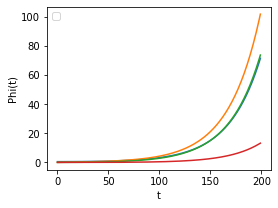

In [15]:
zero_list = [0 for i in range(len(mk_basis) - 1)]
Phi0_vec = [.5] + zero_list

ts=np.linspace(0,1,200)
result = odeint(func=F, y0=Phi0_vec,t=ts,args=(hij_tensor,))
plt.figure(figsize=(4, 3))

#for i in range(len(markov_basis)):
#    plt.plot(result[i], label=r'$\phi_{(%d)}(t)$'%i)

plt.plot(result)

plt.xlabel("t")
plt.ylabel("Phi(t)")
plt.legend()

In [41]:
rhos_at_timet = []

for i in range(len(result)):
    loc_rho = sum([result[i][a] * mk_basis[a] for a in range(len(mk_basis))])
    loc_rho.expm()
    rhos_at_timet.append(loc_rho)
    loc_rho = 0

In [42]:
for i in range(len(rhos_at_timet)):
    #print(me.is_density_op(rhos_at_timet[i]))
    #print(me.ev_checks(rhos_at_timet[i]))
    pass

In [50]:
for i in range(len(rhos_at_timet)):
    if (me.is_density_op(rhos_at_timet[i])):
        print("At time =", i, "density op")
    else:
        pass
        #print("At time =", i, "not density op")

In [7]:
def bures(rho, sigma):
    if (me.is_density_op(rho) and me.is_density_op(sigma)):
        val1 = abs((me.sqrtM(rho)*me.sqrtM(sigma)).tr())
        val1 = max(min(val1,1.),-1.)
        val1 = np.arccos(val1)/np.pi
    else: 
        sys.exit("Singular input matrix")
    return val1

rho1 = (.4*Sx0Sx1).expm()
rho1 = rho1/rho1.tr()
bures(rho0, rho1)

0.007759750761890424

In [9]:
bures_distance_list = [bures(rho0, resultsB["State ev"][a]) for a in range(len(resultsB["State ev"]))]

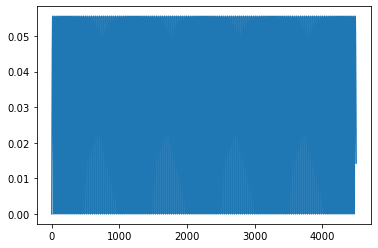

In [10]:
plt.plot(bures_distance_list)

In [8]:
bures(rho0, resultsB["State ev"][4499])

0.01428582964910818

Help on function spin_chain_ev in module auxiliary_library:

spin_chain_ev(size, init_state, chain_type, Hamiltonian_paras, omega_1=3.0, omega_2=3.0, temp=1, tmax=250, deltat=10, two_body_basis=True, unitary_ev=False, gamma=0.1353352832366127, gaussian=True, gr=2, xng=0.5, obs_basis=None, do_project=True)



In [12]:
rho0 = (qutip.tensor([qutip.qeye(2) for k in range(N)]) + .5*seed_op2)
rho0

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[1.   0.   0.   0.   0.   0.   0.25 0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.25]
 [0.   0.   1.   0.   0.25 0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.25 0.   0.  ]
 [0.   0.   0.25 0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.25 0.   1.   0.   0.  ]
 [0.25 0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.25 0.   0.   0.   0.   0.   1.  ]]

In [11]:
start_time = time.time()
unitary_ev = False; gamma = 3*np.pi**-1
size = N = 3; gaussian = True; gr = 2; xng = .7

spin_ops_list = me.one_body_spin_ops(size)
seed_op1 = Mz = sum(spin_ops_list[3][i] for i in range(size))
seed_op2 = Sx0Sx1 = spin_ops_list[1][0]*spin_ops_list[1][0+1] + spin_ops_list[1][1]*spin_ops_list[1][0] 

NN_interactions_on_x = [spin_ops_list[1][a]*spin_ops_list[1][a+1] for a in range(N-1)] 
NN_interactions_on_x + [spin_ops_list[1][N-1]*spin_ops_list[1][0]] 

obs_basis = NN_interactions_on_x
rho0 = (qutip.tensor([qutip.qeye(2) for k in range(N)]) + .5*seed_op2)
rho0 = rho0/rho0.tr()

chain_type = "XYZ"

title, ev_paras, resultsB = me.spin_chain_ev(size = size, init_state = None, chain_type = chain_type, 
                                             Hamiltonian_paras = Hamiltonian_paras, omega_1=3., omega_2=3., 
                                             temp=1, tmax = 150, deltat = 1, two_body_basis = True, 
                                             unitary_ev = unitary_ev, gamma = gamma, gaussian = gaussian, 
                                             gr = gr, xng = xng, obs_basis = obs_basis, do_project = False)

print("--- %s seconds ---" % (time.time() - start_time))

ev_paras["Time elapsed"] = time.time() - start_time

plt.figure(figsize=(8, 6))
plot_labels = ["Sx0Sx1 ", "Sx1Sx2", "Sx2Sx3 ", "Sx3Sx0 "]

for n in range(N):
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n+1], label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

Processing default initial state
Two-body Gaussian initial state chosen
Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 1.25753098e-01+0.00000000e+00j  3.14096598e-04-3.14096598e-04j
   3.14096598e-04-3.14096598e-04j  0.00000000e+00-1.26315775e-04j
   3.14096598e-04-3.14096598e-04j  0.00000000e+00-1.26315775e-04j
   0.00000000e+00-1.26315775e-04j -5.64185785e-07-5.64185785e-07j]
 [ 3.14096598e-04+3.14096598e-04j  1.25124905e-01+0.00000000e+00j
   1.26315775e-04+0.00000000e+00j  1.87780823e-04-1.87780823e-04j
   1.26315775e-04+0.00000000e+00j  1.87780823e-04-1.87780823e-04j
   5.64185785e-07-5.64185785e-07j  0.00000000e+00-1.25187403e-04j]
 [ 3.14096598e-04+3.14096598e-04j  1.26315775e-04+0.00000000e+00j
   1.25124905e-01+0.00000000e+00j  1.87780823e-04-1.87780823e-04j
   1.26315775e-04+0.00000000e+00j  5.64185785e-07-5.64185785e-07j
   1.87780823e-04-1.87780823e-04j  0.00000000e+00-1.25187403e-04j]
 [ 0.00000000e+00+1.26315775e-0

TypeError: Arguments must be quantum objects or eseries

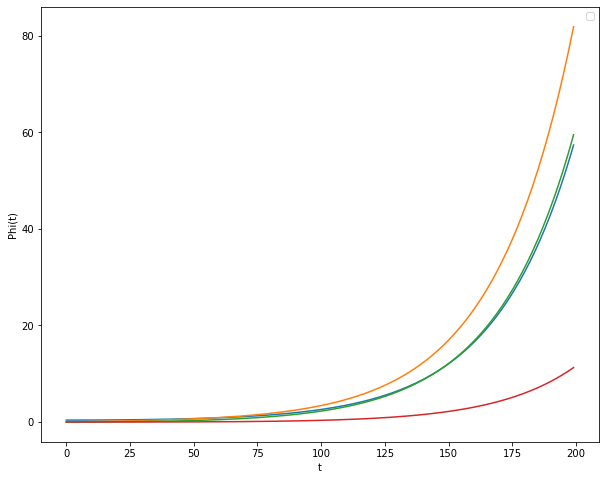

In [22]:
### VersiÃ³n vieja con errores


N = 5

spin_ops_list = me.one_body_spin_ops(N)
seed_op1 = Mz = sum(spin_ops_list[3][i] for i in range(N))
seed_op2 = Sx0Sx1 = spin_ops_list[1][0]*spin_ops_list[1][0+1] + spin_ops_list[1][1]*spin_ops_list[1][0] 

K = .4*seed_op2
rho0 = K.expm()
rho0 = rho0/rho0.tr()

chain_type = "XYZ"
Hamiltonian_paras = [.15, .15, .2, 1.]
H_H = me.Heisenberg_Hamiltonian(spin_ops_list, "XYZ", N, False, Hamiltonian_paras)

mk_basis = me.recursive_basis(N, 4, H_H, seed_op2)
mk_basis = me.base_orth(mk_basis, rho0)

hij_tensor = me.H_ij_matrix(H_H, mk_basis, rho0)

from scipy.integrate import odeint

def F(y, t, HH):
    return HH.dot(y)

zero_list = [0 for i in range(len(mk_basis)-1)]
Phi0_vec = [.4] + zero_list

ts=np.linspace(0,1,200)
result = odeint(func=F, y0=Phi0_vec,t=ts,args=(hij_tensor,))
plt.figure(figsize=(10, 8))

#for i in range(len(markov_basis)):
#    plt.plot(result[i], label=r'$\phi_{(%d)}(t)$'%i)

plt.plot(result)

plt.xlabel("t")
plt.ylabel("Phi(t)")
plt.legend()

In [124]:
basis = mk_basis
basis[0] == Sx0Sx1
basis[1] == me.commutator(H_H, Sx0Sx1)
basis[2] == me.commutator(H_H, me.commutator(H_H, Sx0Sx1))
basis[3] == me.commutator(H_H, me.commutator(H_H, me.commutator(H_H, Sx0Sx1)))
basis[4] == me.commutator(H_H, me.commutator(H_H, me.commutator(H_H, me.commutator(H_H, Sx0Sx1))))

True

In [ ]:
<O>(t)

d/dt <O> = <[H,O]>
d/dt <[H,O]> = <[H, [H,O]]>
d/dt <[H,[H,O]]> = <[H, [H,[H,O]]>


In [ ]:
basis = me.recursive_basis(N, 4, H_H, seed_op2)
mk_basis = [basis[a] + basis[a].dag() for a in range(len(basis))]
mk_basis = me.base_orth(basis, rho0)
mk_basis[0] == basis[0]

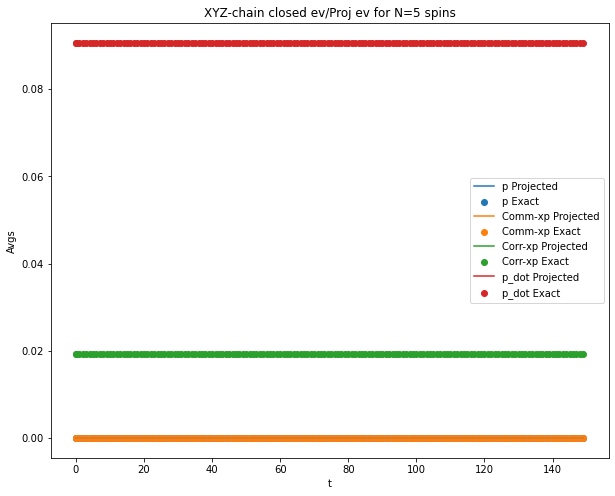

In [12]:
plot_labels = ["p ", "Comm-xp ", "Corr-xp ", "p_dot "]

plt.figure(figsize=(10, 8))
for n in range(4):
    plt.plot(resultsA["ts"], resultsA["averages"][:,n+1], label=plot_labels[n] + "Projected")
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n+1], label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()